<a href="https://colab.research.google.com/github/BeardedBaldo/Dog_Breed_Classifier/blob/main/DogBreedClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import tarfile
import os
from PIL import Image
import time
import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import copy
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
## download stanford dog dataset
url = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
r = requests.get(url, allow_redirects = True) 
open("images.tar", "wb").write(r.content)

In [4]:
### untaring the dataset
tar = tarfile.open("images.tar")
tar.extractall("./")
tar.close()

In [2]:
### check for gpus and assign to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
### image loader function and transform object

imageSize = (128, 128) if torch.cuda.is_available() else (128, 128)

loader = transforms.Compose([transforms.Resize(imageSize), 
                             transforms.ToTensor(),
                             transforms.Normalize((0.485, 0.456, 0.406),
                                                  (0.229, 0.224, 0.225))
                             ])

def imageLoader(imagePath):
  image = Image.open(imagePath)
  image = loader(image).unsqueeze(0)
  return image.to(device, torch.float)


In [4]:
samplePath = './Images/n02085620-Chihuahua/n02085620_10074.jpg'

sampleImage = imageLoader(samplePath)

print(type(sampleImage))
print(sampleImage.size())

<class 'torch.Tensor'>
torch.Size([1, 3, 128, 128])


In [22]:
### variable initialization
dataDir = "./Images"
testSplit = 0.2
epochs = 3
featureExtract = True
modelName = "resnet"

In [6]:
### load data and split into train and test
trainLabels = []
trainImages = []
mapping = []
testLabels = []
testImages = []

sampleList = ['./Images/n02108000-EntleBucher', './Images/n02111889-Samoyed']

for i, (root, dirs, files) in enumerate(os.walk(dataDir)):
  if root != dataDir:# and root in sampleList:    ### add root in sampleList condition only for testing
    name = root.split("/")[-1].split("-")[-1]
    mapping.append(name)
    print(root)
    print(name, " : ", i)
    nFiles = len(files)
    for j, f in enumerate(files):
      filePath = os.path.join(root, f)
      image = imageLoader(filePath)
      if j < (nFiles * (1 - testSplit)):
        trainImages.append(image)
        trainLabels.append(i-1)
      else:
        testImages.append(image)
        testLabels.append(i-1)

trainData = {}
trainData["trainImages"] = trainImages
trainData["trainLabels"] = trainLabels
nClasses = len(mapping)
    
print(trainData.keys())

./Images/n02108422-bull_mastiff
bull_mastiff  :  1
./Images/n02113978-Mexican_hairless
Mexican_hairless  :  2
./Images/n02087046-toy_terrier
toy_terrier  :  3
./Images/n02085936-Maltese_dog
Maltese_dog  :  4
./Images/n02098286-West_Highland_white_terrier
West_Highland_white_terrier  :  5
./Images/n02089973-English_foxhound
English_foxhound  :  6
./Images/n02111889-Samoyed
Samoyed  :  7
./Images/n02097047-miniature_schnauzer
miniature_schnauzer  :  8
./Images/n02093991-Irish_terrier
Irish_terrier  :  9
./Images/n02094433-Yorkshire_terrier
Yorkshire_terrier  :  10
./Images/n02097209-standard_schnauzer
standard_schnauzer  :  11
./Images/n02098413-Lhasa
Lhasa  :  12
./Images/n02096585-Boston_bull
Boston_bull  :  13
./Images/n02113624-toy_poodle
toy_poodle  :  14
./Images/n02100236-German_short-haired_pointer
haired_pointer  :  15
./Images/n02105251-briard
briard  :  16
./Images/n02110958-pug
pug  :  17
./Images/n02113712-miniature_poodle
miniature_poodle  :  18
./Images/n02094114-Norfolk_t

In [7]:
### set requires_grad for model parameters

def setParameterRequiresGrad(model, featureExract):
  if featureExtract:
    for param in model.parameters():
      param.requires_grad = False

In [25]:
### model initialization

def initializeModel(modelName, nClasses, featureExtract, 
                    use_pretrained = True):
  modelFt = None
  inputSize = 0

  if modelName == "resnet":
    modelFt = models.resnet50(pretrained = use_pretrained)
    setParameterRequiresGrad(modelFt, featureExtract)
    nFeatures = modelFt.fc.in_features
    modelFt.fc = nn.Linear(nFeatures, nClasses)
    inputSize = 224

  else:
    print("Invalid model name, exiting...")
    exit()

  return modelFt, inputSize 

modelFt, inputSize = initializeModel(modelName, nClasses,
                                     featureExtract)
print(modelFt)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [26]:
### model GPU initialization, optimizer initialization

## send model to GPU
modelFt = modelFt.to(device)


## print parameters to learn
print("Parameters to learn")
if featureExtract:
  paramsUpdate = []
  for name, param in modelFt.named_parameters():
    if param.requires_grad == True:
      paramsUpdate.append(param)
      print("\t", name)
else:
  paramsUpdate = modelFt.parameters()
  for name, param in modelFt.named_parameters():
    if param.requires_grad == True:
      print("\t", name)


## initialize optimizer
optimizerFt = optim.SGD(paramsUpdate, lr = 0.001, momentum=0.9) 

Parameters to learn
	 fc.weight
	 fc.bias


In [27]:
### model training function

def trainModel(model, trainData, criterion, optimizer,
               nEpochs = 10):
  start = time.time()

  accHistory = []

  bestModelWts = copy.deepcopy(model.state_dict())
  bestAcc = 0

  for epoch in range(nEpochs):
    print(f'Epoch {epoch}/{nEpochs - 1}')
    print('-' * 10)

    runningLoss = 0.0
    runningCorrects = 0

    inputs = trainData["trainImages"]
    labels = trainData["trainLabels"]

    for i, input in enumerate(inputs):
      input = input.to(device)
      label = []
      label.append(labels[i])
      label = torch.tensor(np.array(label)).to(device)
      
      ##zero gradients
      optimizer.zero_grad()

      output = model(input)
      loss = criterion(output, label)

      _, prediction = torch.max(output, 1)

      loss.backward()
      optimizer.step()

      runningLoss += loss.item() * input.size(0)
      runningCorrects += torch.sum(prediction == label)

    epochLoss = runningLoss / (len(inputs))
    epochAcc = runningCorrects.double() / (len(inputs))

    print("epoch accuracy: {:4f}, epoch loss: {:4f}".format(epochLoss, epochAcc))

    if epochAcc > bestAcc:
      bestAcc = epochAcc
      bestModelWts = copy.deepcopy(model.state_dict())

    accHistory.append(epochAcc)

  timeTaken = time.time() - start
  print("training complete in {:.0f}m {:.0f}s".format(timeTaken // 60,
                                         timeTaken % 60))
  
  print("Best training accuracy: {:4f}".format(bestAcc))

  model.load_state_dict(bestModelWts)

  return model, accHistory




In [28]:
criterion = nn.CrossEntropyLoss()

modelFt, hist = trainModel(modelFt, trainData, criterion,
                           optimizerFt, nEpochs = epochs)

Epoch 0/2
----------
epoch accuracy: 4.440709, epoch loss: 0.892894
Epoch 1/2
----------
epoch accuracy: 4.583510, epoch loss: 0.890713
Epoch 2/2
----------
epoch accuracy: 4.559282, epoch loss: 0.890774
training complete in 7m 30s
Best training accuracy: 0.892894


No handles with labels found to put in legend.


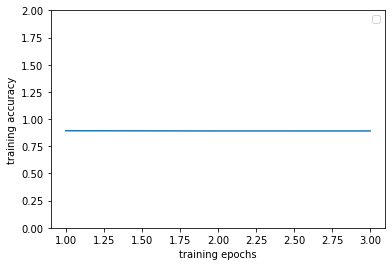

In [29]:
###
ohist = [h.cpu().numpy() for h in hist]

plt.xlabel("training epochs")
plt.ylabel("training accuracy")
plt.plot(range(1, epochs+1), ohist)
plt.ylim((0, 2.))
plt.legend()
plt.show()

In [ ]:
### model evaluation

total = 0
correct = 0

with torch.no_grad():
  inputs = testImages
  labels = testLabels
  for i, input in enumerate(inputs):
      input = input.to(device)
      label = []
      label.append(labels[i])
      label = torch.tensor(np.array(label)).to(device)
      output = modelFt(input)
      _, predicted = torch.max(output, 1)
      print("Label:", int(label[0]), ", Predicted:", int(predicted[0]))
      total += label.size(0)
      correct += (predicted==label).sum().item()

print("Testing accuracy: ", (correct/total) * 100)


In [31]:
print(output[0])

tensor([-1.2907e+01, -1.0285e+01, -7.8960e+00, -5.2009e+00, -3.8195e+00,
        -1.6485e+00, -2.1505e+00, -1.6235e+00, -5.4082e-01, -7.3362e-01,
         1.1011e-01, -1.0666e-01, -1.7674e-01,  3.7786e-02, -5.7962e-01,
         1.8774e-02,  1.3444e-01, -3.0506e-01, -9.2712e-03, -4.2012e-01,
        -4.0219e-01, -2.7865e-01,  8.4893e-02, -1.7575e-01, -3.4366e-01,
         2.0460e-02, -2.1293e-01, -4.3838e-01, -7.9507e-02, -4.0448e-01,
        -3.1550e-01, -2.6959e-01, -5.7543e-01, -2.1767e-01, -2.9930e-01,
        -1.2228e-01, -3.5730e-01, -4.5639e-03, -6.6616e-01, -2.8697e-01,
        -1.3604e-01, -2.4045e-01, -2.2180e-01, -3.8537e-01, -1.5604e-01,
        -2.9639e-01, -5.3931e-02, -3.0215e-01, -1.6247e-01, -2.2469e-01,
        -4.1323e-01, -5.8748e-01, -3.4711e-01, -2.5672e-01, -2.9197e-01,
        -1.2130e-01, -1.0437e-01,  1.6361e-01, -2.1395e-01, -4.4956e-01,
        -2.8106e-01, -1.4230e-02, -3.1875e-01, -1.7662e-01, -1.4248e-01,
        -9.7972e-02, -2.8228e-01, -2.7373e-01, -2.5

In [33]:
### prediction 
predictPath = "./Images/n02085620-Chihuahua/n02085620_10074.jpg"

def predictBreed(predictPath, model, mapping):
  input = imageLoader(predictPath)
  with torch.no_grad():
    input = input.to(device)
    output = model(input)
    _, predicted = torch.max(output, 1)
    predictedLabel = int(predicted[0])
    predictedBreed = mapping[predictedLabel]

  return predictedBreed

predictBreed = predictBreed(predictPath, modelFt, mapping)



In [34]:
print(predictBreed)
print(trainLabels)

Lakeland_terrier
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

In [35]:
print(mapping[120])

Lakeland_terrier


In [100]:
print(len(mapping))

121
